In [3]:
# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import scipy.io
import torch
import time
import os
import matplotlib.pyplot as plt
# Modules
from AC_precompute import inputs, gram_schmidt1_double, gram_schmidt2_double
from AC_test import gpt_test, gpt_test_loss
from AC_GPT_train import offline_generation,offline_generation_GD
from AC_SA_PINN import NN
from AC_SA_train import sa_pinn_train
from AC_models import P
from pyDOE import lhs


data_dir = "./ac_data/random/"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Force CUDA initialization
dummy = torch.tensor([0.0]).to(device)

print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

#device = torch.device("cuda")
print_seperator = 60*"*"

sparse = True

if (sparse):
    ext = "s"
else:
    ext = ""

print(f"Start: {datetime.now()}\n")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB
Start: 2025-01-03 13:07:49.257383



In [4]:
#### Domain and simulated data ####
N0  = 512
N_b = 100
N_f = 20000

data = scipy.io.loadmat('/dssg/home/acct-matxzl/matxzl/Yajie/GPT_PINN3/Sparse_GPT-PINN/Allen Cahn/AC.mat')
t = data['tt'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact_u = data['uu']

#### SA-PINN ####
# IC (Initial Condition)
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x, :]
u0 = torch.tensor(Exact_u[idx_x, 0:1], dtype=torch.float32).to(device)
X0 = np.concatenate((x0, 0 * x0), 1)
x0 = torch.tensor(X0[:, 0:1], dtype=torch.float32).to(device)
t0 = torch.tensor(X0[:, 1:2], dtype=torch.float32).to(device)

# BC (Boundary Condition)
lb = np.array([-1.0]) 
ub = np.array([1.0])

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]

X_lb = np.concatenate((0 * tb + lb[0], tb), 1)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1)
x_lb = torch.tensor(X_lb[:, 0:1], dtype=torch.float32).to(device)
t_lb = torch.tensor(X_lb[:, 1:2], dtype=torch.float32).to(device)
x_ub = torch.tensor(X_ub[:, 0:1], dtype=torch.float32).to(device)
t_ub = torch.tensor(X_ub[:, 1:2], dtype=torch.float32).to(device)

# Collocation Points
X_f = lb + (ub - lb) * lhs(2, N_f)
x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32).to(device)
t_f = torch.tensor(np.abs(X_f[:, 1:2]), dtype=torch.float32).to(device)

#### GPT ####
# IC (Initial Condition)
val, idx = torch.sort(torch.tensor(X0[:, 0:1].flatten()))
IC_u = torch.tensor(Exact_u[idx_x, 0:1], dtype=torch.float32)[idx].to(device)

IC_xt = torch.hstack((torch.tensor(X0[idx, 0:1], dtype=torch.float32), 
                      torch.tensor(X0[:, 1:2], dtype=torch.float32))).to(device)

# BC (Boundary Condition)
x_lb_py = torch.tensor(X_lb[:, 0:1], dtype=torch.float32).to(device)
t_lb_py = torch.tensor(X_lb[:, 1:2], dtype=torch.float32).to(device)
x_ub_py = torch.tensor(X_ub[:, 0:1], dtype=torch.float32).to(device)
t_ub_py = torch.tensor(X_ub[:, 1:2], dtype=torch.float32).to(device)

BC_xt_ub = torch.hstack((x_ub_py, t_ub_py)).to(device).requires_grad_()
BC_xt_lb = torch.hstack((x_lb_py, t_lb_py)).to(device).requires_grad_()

# Collocation Points
xt_resid = torch.hstack((torch.tensor(X_f[:, 0:1], dtype=torch.float32), 
                         torch.tensor(np.abs(X_f[:, 1:2]), dtype=torch.float32))).to(device).requires_grad_()
f_hat = torch.zeros(20000, 1).to(device)

# Test Data
x_test, t_test = torch.meshgrid(torch.linspace(-1, 1, 60),
                                torch.linspace(0, 1, 60), indexing="ij")

xt_test = torch.hstack((x_test.transpose(1, 0).flatten().unsqueeze(1), 
                        t_test.transpose(1, 0).flatten().unsqueeze(1))).to(device)

#### Training parameter set ####
Lmbda        = np.linspace(1e-3,1e-4,11)
Eps          = np.linspace(1,5,11)
ac_train     = np.array(np.meshgrid(Lmbda, Eps)).T.reshape(-1,2)
ac_train_all = ac_train.copy() 

#### SA-PINN attributes ####
lr_adam_sa  = 0.001
lr_weights  = 0.001
lr_lbfgs_sa = 0.1
tol_adam    = 1e-3

epochs_adam_sa  = 50000
epochs_lbfgs_sa = 1000

layers_pinn = [2, 128, 128, 128, 128, 1]

In [5]:
#### GPT-PINN attributes ####
number_of_neurons = 12
if (sparse):
    lr_gpt = 0.01
else:   
    lr_gpt = 0.0025
epochs_gpt_train  = 2000

test_cases      = np.ceil(0.2*len(ac_train)).astype(int)
epochs_gpt_test = 5000

loss_list  = np.zeros(number_of_neurons)
loss_list1  = np.zeros(number_of_neurons)
neurons    = np.zeros((number_of_neurons,2))
neurons0    = np.zeros((number_of_neurons,2))

# Two kinds of initializations for the neurons
neurons[0] = (np.median(Lmbda), np.median(Eps))
neurons[0] = (0.001, 1.0)
neurons0[0] = (0.001, 1.0)
#neurond[0] = ac_train[np.random.randint(low=0, high=len(ac_train))]

c_init = np.zeros(number_of_neurons, dtype=object)
for i in range(number_of_neurons):
    c_init[i] = torch.full((1,i+1), 1/(i+1)).to(device)
    
#### Data sizes ####
test_size = xt_test.shape[0]
xt_size   = xt_resid.shape[0]
IC_size   = IC_xt.shape[0]
BC_size   = BC_xt_ub.shape[0]    

if (sparse):
    #### Training point data ####
    X_train_all   = torch.zeros((2*number_of_neurons-1,2)).to(device)
    X_all_idx     = torch.zeros( 2*number_of_neurons-1, dtype=torch.long).to(device)
    X_umax_idx    = torch.zeros(   number_of_neurons,   dtype=torch.long).to(device)
    X_rmax_idx    = torch.zeros(   number_of_neurons-1, dtype=torch.long).to(device)
    residual_full = torch.zeros((xt_size, number_of_neurons-1), dtype=torch.float64).to(device)

#### Neuron outputs on the full training grid ####
out_full    = torch.zeros((xt_size, number_of_neurons), dtype=torch.float64).to(device)
out_t_full  = torch.zeros((xt_size, number_of_neurons), dtype=torch.float64).to(device)
out_xx_full = torch.zeros((xt_size, number_of_neurons), dtype=torch.float64).to(device)
out_IC      = torch.zeros((IC_size, number_of_neurons), dtype=torch.float64).to(device)

out_BC_ub   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float64).to(device)
out_BC_lb   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float64).to(device)
out_BC_diff = torch.zeros((BC_size, number_of_neurons), dtype=torch.float64).to(device)

out_BC_ub_x   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float64).to(device)
out_BC_lb_x   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float64).to(device)
out_BC_diff_x = torch.zeros((BC_size, number_of_neurons), dtype=torch.float64).to(device)

#### Neuron outputs on the full training grid ####
out_test    = torch.zeros((test_size, number_of_neurons), dtype=torch.float32).to(device) 

************************************************************


/dssg/home/acct-matxzl/matxzl/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1837 | Loss: 0.000983059057034552 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 56 | Loss: 9.862290607998148e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 0.57770277261734 minutes

(0.001,1.4) stopped with the loss: 5.241904727881774e-05
(0.001,1.8) stopped with the loss: 6.146007945062593e-05
(0.001,2.2) stopped with the loss: 6.141689664218575e-05
(0.001,2.6) stopped with the loss: 6.426499749068171e-05
(0.001,3.0) stopped with the loss: 0.0001004323858069256
(0.001,3.4000000000000004) stopped with the loss: 9.616449096938595e-05
(0.001,3.8000000000000003) stopped with the loss: 7.739526336081326e-05
(0.001,4.2) stopped with the loss: 8.682867337483913e-05
(0.001,4.6) stopped with the loss: 7.407963130390272e-05
(0.001,5.0) stopped with the loss: 7.729625212959945e-05
(0.00091,1.0) stopped with the loss: 6.017705163685605e-05
(0.00091,1.4) stopped with the loss: 7.604838174302131e-05
(0.00091,1.8) stopped wi

/tmp/ipykernel_3255898/3596300424.py:71: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(((out_test[:,:i+1]@trained_c.T)).reshape(60,60).detach().cpu().numpy())


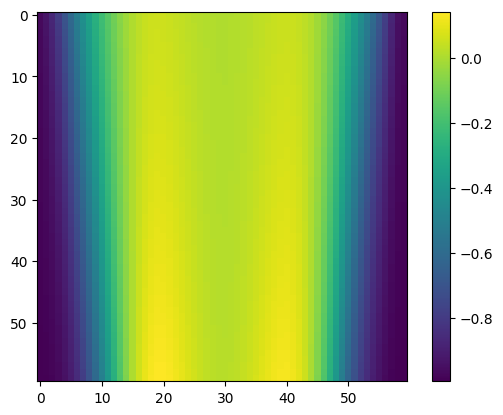

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.e-03 1.e+00]
 [1.e-03 3.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]]

Loss list: (array([0.00010043, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 8800 | Loss: 0.0009877372067421675 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 162 | Loss: 9.926678467309102e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 2.080788818995158 minutes

(0.001,1.4) stopped with the loss: 0.0019642554689198732
(0.001,1.8) stopped wit

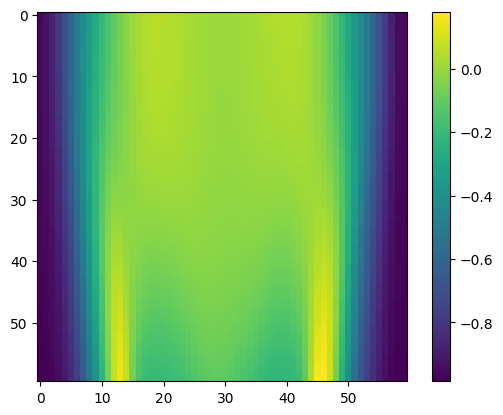

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.e-03 1.e+00]
 [1.e-03 3.e+00]
 [1.e-04 5.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.3571036458015442 	 ep time: 0.004780462011694908
Epoch: 20000 | loss: 0.027328887954354286 	 ep time: 0.00477369362488389
Epoch: 25180 | Loss: 0.0009591734269633889 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch

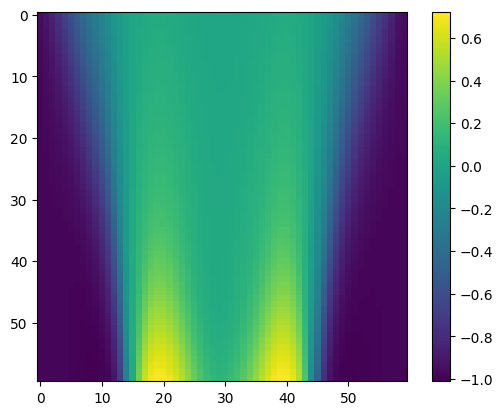

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.13575665652751923 	 ep time: 0.0051819439977407455
Epoch: 20000 | loss: 0.014724381268024445 	 ep time: 0.00515897199511528
Epoch: 30000 | loss: 0.010171139612793922 	 ep time: 0.005134698003530502
Epoch: 33808 | Loss: 0.

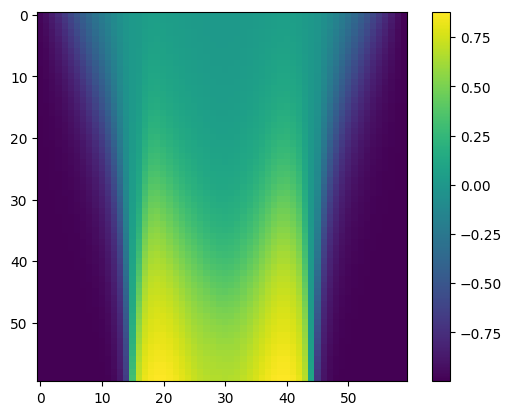

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.004494251683354378 	 ep time: 0.00515334028750658
Epoch: 12173 | Loss: 0.0009727911092340946 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 123 | Loss: 9.883951861411333e-05 (Stopp

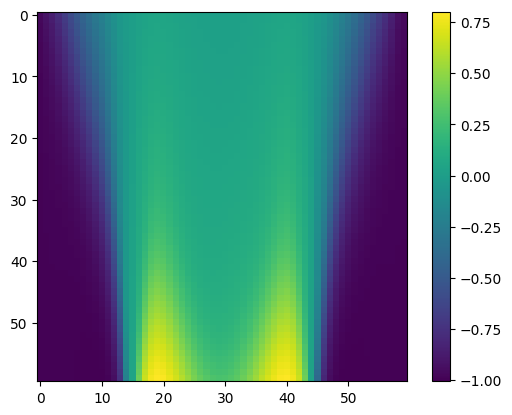

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.1463381052017212 	 ep time: 0.005192282143980265
Epoch: 20000 | loss: 0.7952192425727844 	 ep time: 0.005152278114110231
Epoch: 30000 | loss: 0.0031618517823517323 	 ep time: 0.005186042282730341
Epoch: 34090 | Loss: 0.00

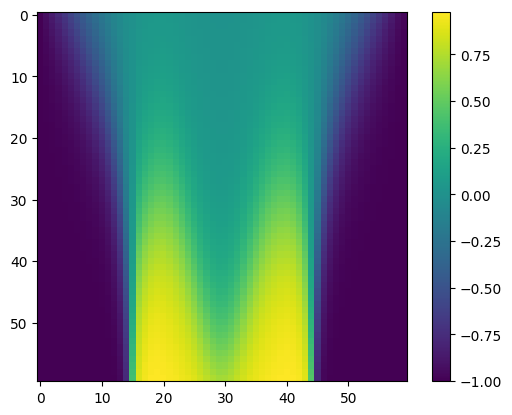

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.1362188309431076 	 ep time: 0.005147924181073904
Epoch: 20000 | loss: 0.1437561959028244 	 ep time: 0.0051629990339279175
Epoch: 30000 | loss: 1.0247008800506592 	 ep time: 0.005156605038791895
Epoch: 38894 | Loss: 0.0009

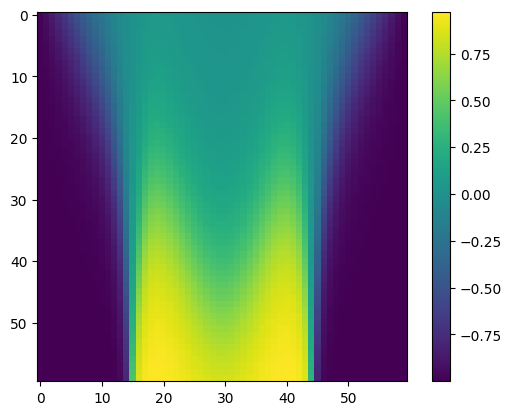

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.004181681200861931 	 ep time: 0.00515499385073781
Epoch: 14992 | Loss: 0.000966544495895505 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 144 | Loss: 9.809799666982144e-05 (Stoppi

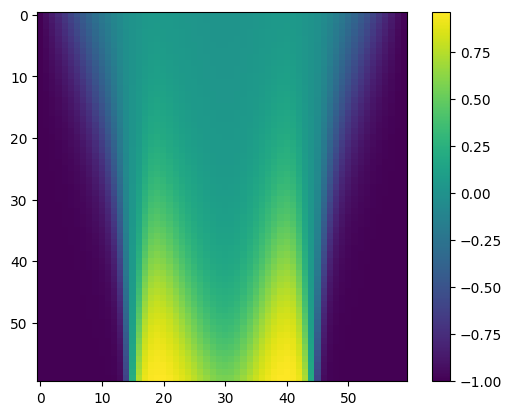

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.15576699376106262 	 ep time: 0.00516893994063139
Epoch: 19620 | Loss: 0.0009623481309972703 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 346 | Loss: 9.946544014383107e-05 (Stoppi

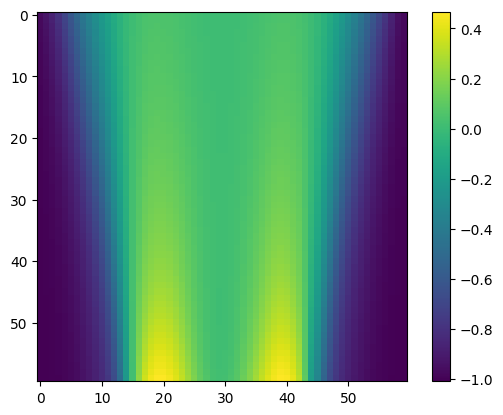

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       6.72293594e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 3184 | Loss: 0.0009954527486115694 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 50 | Loss: 9.847291221376508e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 0.723083400

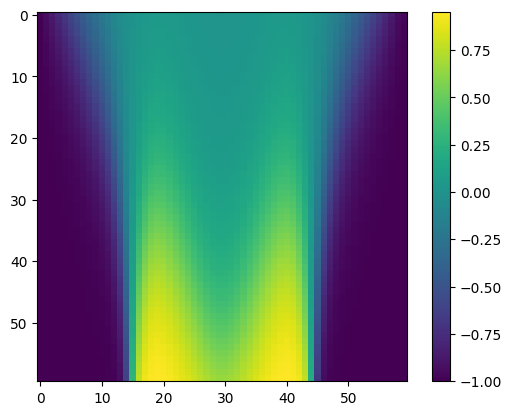

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [7.3e-04 4.2e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       6.72293594e-03, 4.23306599e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 9986 | Loss: 0.0009933278197422624 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 333 | Loss: 9.997437155107036e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 3.26483629

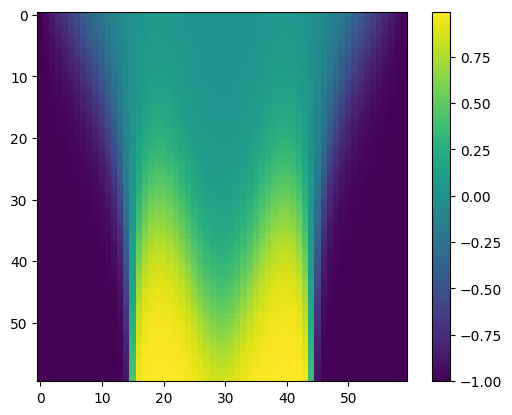

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [7.3e-04 4.2e+00]
 [3.7e-04 5.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       6.72293594e-03, 4.23306599e-03, 2.73560639e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.140075221657753 	 ep time: 0.005170861724764109
Epoch: 20000 | loss: 0.0028470088727772236 	 ep time: 0.005187730770558119
Epoch: 26834 | Loss: 0.00099969154689461 (Stopping Criteria Met)
SA-PINN Adam training completed!


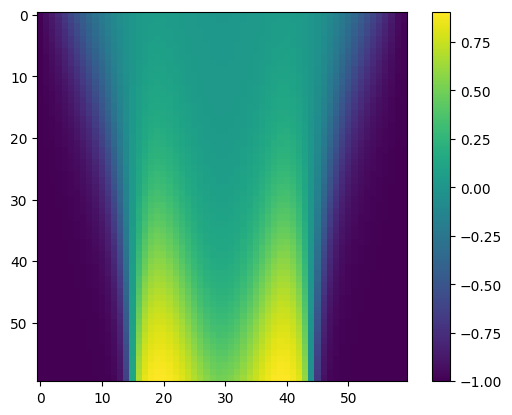

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [7.3e-04 4.2e+00]
 [3.7e-04 5.0e+00]
 [1.0e-03 3.8e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       6.72293594e-03, 4.23306599e-03, 2.73560639e-03, 2.25183158e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.0017909384332597256 	 ep time: 0.005158260930329561
Epoch: 12592 | Loss: 0.0009853392839431763 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 172 | Loss: 9.74898284766823e-05 (Stop

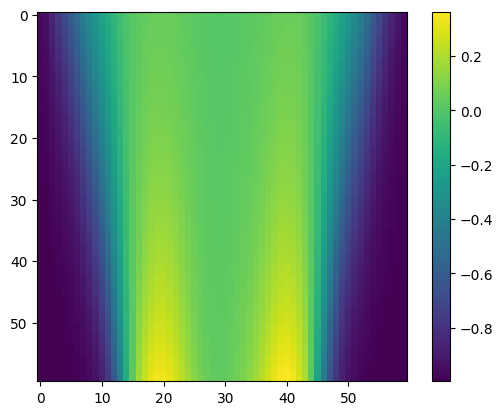

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [7.3e-04 4.2e+00]
 [3.7e-04 5.0e+00]
 [1.0e-03 3.8e+00]
 [1.9e-04 2.2e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       6.72293594e-03, 4.23306599e-03, 2.73560639e-03, 2.25183158e-03,
       1.42339419e-03, 0.00000000e+00, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 4566 | Loss: 0.0009814149234443903 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 59 | Loss: 9.875960677163675e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 0.969454129

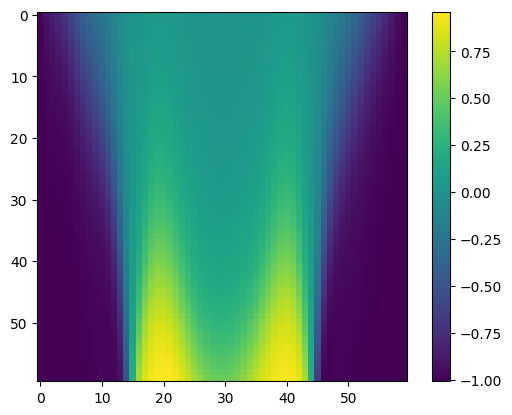

torch.Size([20000, 1])
Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [7.3e-04 4.2e+00]
 [3.7e-04 5.0e+00]
 [1.0e-03 3.8e+00]
 [1.9e-04 2.2e+00]
 [9.1e-04 5.0e+00]]

Loss list: (array([1.00432386e-04, 4.91003186e-01, 1.53294951e-02, 1.53898569e-02,
       9.82293561e-02, 1.49579141e-02, 1.79794244e-02, 8.20842572e-03,
       6.72293594e-03, 4.23306599e-03, 2.73560639e-03, 2.25183158e-03,
       1.42339419e-03, 2.31637489e-02, 0.00000000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

************************************************************
Epoch: 10000 | loss: 0.13423451781272888 	 ep time: 0.005164783913642168
Epoch: 20000 | loss: 0.9609865546226501 	 ep time: 0.005202980246394873
Epoch: 30000 | loss: 0.0013825775822624564 	 ep time: 0.0051950737833976746
Epoch: 30439 | Loss: 0.

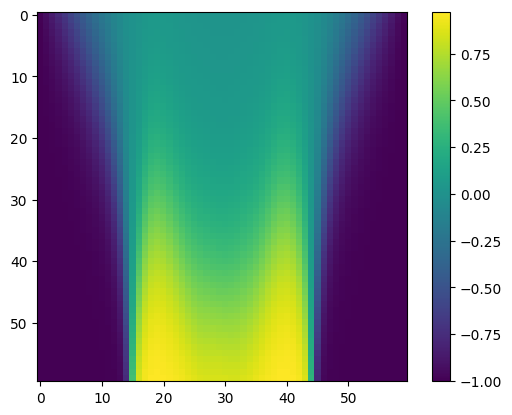

************************************************************
Total Training Time: 1.1504938250780106 Hours

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-04 5.0e+00]
 [1.9e-04 5.0e+00]
 [1.0e-04 3.4e+00]
 [5.5e-04 5.0e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 4.6e+00]
 [1.0e-03 1.8e+00]
 [7.3e-04 4.2e+00]
 [3.7e-04 5.0e+00]
 [1.0e-03 3.8e+00]
 [1.9e-04 2.2e+00]
 [9.1e-04 5.0e+00]]

Loss list: [1.00432386e-04 4.91003186e-01 1.53294951e-02 1.53898569e-02
 9.82293561e-02 1.49579141e-02 1.79794244e-02 8.20842572e-03
 6.72293594e-03 4.23306599e-03 2.73560639e-03 2.25183158e-03
 1.42339419e-03 2.31637489e-02 1.16054667e-03]



In [6]:
generation_time = np.zeros(number_of_neurons)
###############################################################################
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    
    # Don't need to train over parameters already used as neurons
    ac_train = np.delete(ac_train, np.where(np.all(ac_train == neuron, 
                                                   axis=1))[0], axis=0)    
    ###########################################################################
    # SA-PINN to be used as activation function
    lmbda, eps = neuron
    
    t1 = time.time()
    PINN = NN(layers_pinn, lmbda, eps).to(device)
    sa_pinn_train(PINN, lr_adam_sa, lr_weights, lr_lbfgs_sa, epochs_adam_sa, epochs_lbfgs_sa, tol_adam, xt_resid, f_hat, IC_xt, IC_u, 
                     BC_xt_ub, BC_xt_lb)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    #plt.imshow(PINN(xt_test).reshape(60,60).detach().cpu().numpy())
    ###########################################################################    
    # (S)GPT-PINN Training / Offline Generation
    c_initial  = c_init[i][0]
            
    if (sparse): # SGPT
        train_out, train_out_xx, train_out_t, train_out_IC, train_out_BC_ub, \
        train_out_BC_lb, train_out_BC_diff, fhat, train_len, train_out_BC_ub_x,\
        train_out_BC_lb_x, train_out_BC_diff_x,ALPHA = gram_schmidt1_double(PINN, i, xt_resid, 
        IC_xt, BC_xt_ub, BC_xt_lb, out_full, out_xx_full, out_t_full, out_IC, 
        out_BC_ub, out_BC_lb, X_umax_idx, X_all_idx, X_train_all, xt_test, 
        out_test, f_hat, out_BC_diff, out_BC_ub_x, out_BC_lb_x, out_BC_diff_x)  
        if i==0:
            c_ui           = PINN(xt_resid)
            c_x_umax_idx = torch.argmax(torch.abs(c_ui))
            if c_ui[c_x_umax_idx]<0:
                c_initial[i] = -1.0
        else:
            c_initial[:i] = ALPHA.squeeze()
            c_initial[i] = 0.0

        largest_loss, largest_case, trained_c = offline_generation(ac_train, c_initial, 
        train_len, IC_size, BC_size, IC_u, train_out, train_out_t, train_out_xx, 
        train_out_IC, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
        train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x, fhat, 
        epochs_gpt_train, lr_gpt)

    else: # GPT
        train_out, train_out_xx, train_out_t, train_out_IC, train_out_BC_ub, \
        train_out_BC_lb, train_out_BC_diff, fhat, train_len, train_out_BC_ub_x,\
        train_out_BC_lb_x, train_out_BC_diff_x = inputs(PINN, xt_resid, out_full, 
        out_xx_full, out_t_full, out_IC, out_BC_ub, out_BC_lb, IC_xt, BC_xt_ub, 
        BC_xt_lb, i, out_test, xt_test, f_hat, xt_size, out_BC_diff, out_BC_ub_x, 
        out_BC_lb_x, out_BC_diff_x)

        largest_loss, largest_case, trained_c = offline_generation_GD(ac_train, c_initial, 
        train_len, IC_size, BC_size, IC_u, train_out, train_out_t, train_out_xx, 
        train_out_IC, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
        train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x, fhat, 
        epochs_gpt_train, lr_gpt)

    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes")  
    
    ###########################################################################
    loss_list[i] = largest_loss
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case
        neurons0[i+1] = (np.random.choice(Lmbda),np.random.choice(Eps))
        print(f"Parameter Case: {neurons[i+1]}\n")
    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    plt.imshow(((out_test[:,:i+1]@trained_c.T)).reshape(60,60).detach().cpu().numpy())
    plt.colorbar()
    plt.show()
    if (i == number_of_neurons-1):
        break
    
    ###########################################################################
    
    if (sparse):
        lmbda, eps = largest_case
        gram_schmidt2_double(i, xt_resid, lmbda, eps, trained_c, residual_full, out_full, 
                      out_xx_full, out_t_full, X_rmax_idx, X_all_idx, X_train_all)
                     
    print(f"Activation Function Parameters: \n{neurons}\n")
    #print(f"Activation Function Parameters: \n{neurons0}\n")
    print(f"Loss list: {loss_list,loss_list1}\n")
total_time = (time.time() - total_time_1) / 3600

print(print_seperator)
print(f"Total Training Time: {total_time} Hours\n")
print(f"Activation Function Parameters: \n{neurons}\n")
print(f"Loss list: {loss_list}\n")

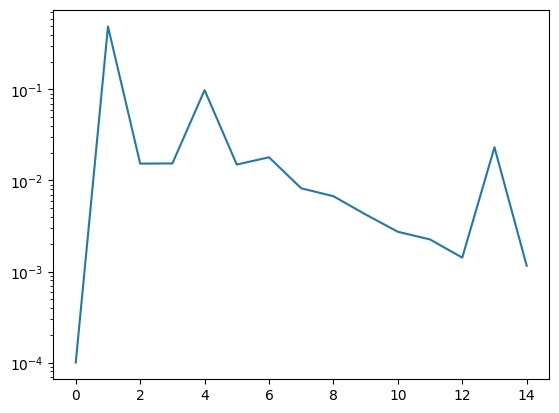

In [8]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

In [7]:
print({stop})

NameError: name 'stop' is not defined

In [ ]:
if (sparse):
    np.savetxt(data_dir+"/X_train_all.dat", X_train_all.detach().cpu().numpy())
    np.savetxt(data_dir+"/X_all_idx.dat",   X_all_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_umax_idx.dat",  X_umax_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_rmax_idx.dat",  X_rmax_idx.cpu().numpy())
np.savetxt(data_dir+f"/generation_time_{ext}gpt.dat", generation_time)
np.savetxt(data_dir+f"/loss_list_{ext}gpt.dat",       loss_list)
np.savetxt(data_dir+f"/neurons_{ext}gpt.dat",         neurons)
np.savetxt(data_dir+f"/total_time_{ext}gpt.dat",      np.array([total_time]))

In [ ]:
#### Test ####
# PINN losses are computed separately due to recording them negatively effecting true run times

ac_test = np.array(np.meshgrid(Lmbda, Eps)).T.reshape(-1,2)

print(f"{ext.upper()}GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test(ac_test, train_out, train_out_t, train_out_xx, 
train_out_IC, fhat, train_len, IC_size, BC_size, IC_u, c_initial, epochs_gpt_test, 
lr_gpt, out_test, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x)

test_gpt_losses = gpt_test_loss(ac_test, train_out, train_out_t, train_out_xx, 
train_out_IC, fhat, train_len, IC_size, BC_size, IC_u, c_initial, epochs_gpt_test, 
lr_gpt, out_test, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x)
print(f"{ext.upper()}GPT-PINN Testing Ended")

SGPT-PINN Testing Started
SGPT-PINN Testing Ended


In [ ]:
np.savetxt(data_dir+f"/test_{ext}gpt_losses.dat", test_gpt_losses)
np.savetxt(data_dir+f"/test_{ext}gpt_soln.dat",   test_gpt_soln)
np.savetxt(data_dir+f"/test_{ext}gpt_time.dat",   test_gpt_time+total_time)


In [ ]:
print(c_initial)

tensor([-0.9999,  0.9050, -0.0324,  0.0012,  0.2731, -0.0164,  0.0705, -0.0200,
        -0.0137, -0.0380, -0.0450,  0.0225,  0.0648, -0.0236,  0.0000],
       device='cuda:0')
